In [88]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
from sklearn.metrics import precision_recall_curve
from matplotlib.patches import Rectangle
import statsmodels.api as sm
import matplotlib

In [89]:
#family_id = '11002'
#family_id = '11089'
ped_file = '../../DATA/ssc/ssc.ped'
chroms = [str(x) for x in range(1, 23)]

assembly = '37'

In [90]:
colors=['#ef6c00', '#4db6ac', '#ce93d8ff']

In [91]:
ssc_old_id_to_new_id = dict()
with open('../data/ssc.id_map.from.repository', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        ssc_old_id_to_new_id[pieces[1]] = pieces[0]
        ssc_old_id_to_new_id[pieces[1].replace('.', '_')] = pieces[0]

In [92]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if child_id in ssc_old_id_to_new_id and m_id in ssc_old_id_to_new_id and f_id in ssc_old_id_to_new_id:
                child_id = ssc_old_id_to_new_id[child_id]
                f_id = ssc_old_id_to_new_id[f_id]
                m_id = ssc_old_id_to_new_id[m_id]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

                if (fam_id, m_id, f_id) not in fam_to_inds:
                    fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
                
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 1037


# pull our deletions

In [93]:
# pull deletions
deletions = []
with open('../phased_ssc_del_qs/deletions.json') as f:
    for d in json.load(f):
        if d['is_inherited'] and not d['is_hts']:
            for child in d['trans']:
                if '%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child) in d:
                    deletions.append({
                                'family': d['family'],
                                'child': ssc_old_id_to_new_id[child],
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': ssc_old_id_to_new_id[d['mother']],
                                'father': ssc_old_id_to_new_id[d['father']],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                #'num_markers': d['num_markers'],
                                'num_markers_aCGH': d['%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child)],
                                'med_aCGH': d['%s_med_aCGH' % ssc_old_id_to_new_id.get(child, child)],
                                'quality_score': None if 'quality_score' not in d else d['quality_score']
                        })
print(len(deletions))

31231


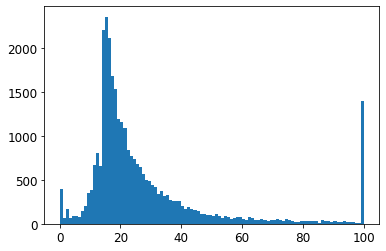

In [94]:
plt.hist(np.clip([d['quality_score'] for d in deletions if d['quality_score'] is not None], None, 100), 
         bins=np.arange(101))
plt.show()

In [95]:
#chroms = [str(x) for x in range(1, 23)]
#chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)
#
#
## pull cytobands
#intervals = []
#
#with open('../data/cytoBand%s.txt' % assembly, 'r') as f:
#    for line in f:
#        pieces = line.strip().split('\t')
#        if pieces[0][3:] in chroms:
#            intervals.append((pieces[0][3:], pieces[3], int(pieces[1]), int(pieces[2]), pieces[4]))
#intervals = sorted(intervals, key=lambda x: (int(x[0]), x[2]))#
#
#interval_chroms = np.array([int(x[0]) for x in intervals])
#first_chrom = [0] + np.where(interval_chroms[1:] != interval_chroms[:-1])[0].tolist()
#
## filter deletions that go through the centromere
#centromeres = [x for x in intervals if x[-1] == 'acen']
#centromeric_deletions = []
#for i, d in enumerate(deletions):
#    for chrom, _, start_pos, end_pos, _ in centromeres:
#        if d['chrom'] == chrom:
#            overlap = min(end_pos, d['end_pos']) - max(start_pos, d['start_pos'])
#            if overlap > 0:
#                centromeric_deletions.append(d)
#print(len(centromeric_deletions))

# pull sebat deletions

In [96]:
# pull deletions
#sebat_deletions = []
#with open('../phased_ssc.sebat_del/deletions.json') as f:
#    for d in json.load(f):
#        if d['is_inherited']:
#            for child in d['trans']:
#                if '%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child) in d:
#                    sebat_deletions.append({
#                                'family': d['family'],
#                                'child': child,
#                                'chrom': d['chrom'],
#                                'start_pos': d['start_pos'],
#                                'end_pos': d['end_pos'],
#                                'length': d['length'],
#                                'opt_start_pos': d['opt_start_pos'],
#                                'opt_end_pos': d['opt_end_pos'],
#                                'is_mat': d['is_mat'],
#                                'is_pat': d['is_pat'],
#                                'mother': d['mother'],
#                                'father': d['father'],
#                                'is_inherited': d['is_inherited'],
#                                'is_denovo': d['is_denovo'],
#                                'num_markers_ssc': d['num_markers_ssc'],
#                                'num_markers_aCGH': d['%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child)],
#                                'med_aCGH': d['%s_med_aCGH' % ssc_old_id_to_new_id.get(child, child)]
#                        })
#print(len(sebat_deletions))

In [97]:
#remove deletions that aren't inherited
deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))

#sebat_deletions = [d for d in sebat_deletions if d['is_inherited']]
#print('remaining deletions', len(sebat_deletions))

remaining deletions 31231


In [98]:
#remove deletions <100bp
deletions = [d for d in deletions if d['length']>=1000]
print('remaining deletions', len(deletions))

#sebat_deletions = [d for d in sebat_deletions if d['length']>=1000]
#print('remaining deletions', len(sebat_deletions))

remaining deletions 20935


In [99]:
chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)
chrom_to_region_types = defaultdict(list)
#with open('../data/filtered_regions_hg19.bed', 'r') as f:
#    for line in f:
#        pieces = line.strip().split('\t')
#        if pieces[0][3:] in chroms:
##            if pieces[3]=='centromere':
##                chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1])+1)
#                chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
#                chrom_to_region_types[pieces[0][3:]].append(pieces[3])

with open('../data/centromere37.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1])+1)
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
            chrom_to_region_types[pieces[0][3:]].append('centromere')
            
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1])+1-2000000)
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[1]))
            chrom_to_region_types[pieces[0][3:]].append('pericentromere')
            
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[2])+1)
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2])+2000000)
            chrom_to_region_types[pieces[0][3:]].append('pericentromere')
            
with open('../data/telomere37.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1])+1)
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
            chrom_to_region_types[pieces[0][3:]].append('telomere')
            
            if int(pieces[1])==0:
                chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[2])+1)
                chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2])+2000000)
                chrom_to_region_types[pieces[0][3:]].append('subtelomere')
            else:
                chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1])+1-2000000)
                chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[1]))
                chrom_to_region_types[pieces[0][3:]].append('subtelomere')
            
            
            
#with open('../data/microsat.txt', 'r') as f:
#    for line in f:
#        pieces = line.strip().split('\t')
#        if pieces[1][3:] in chroms:
#            chrom_to_interval_starts[pieces[1][3:]].append(int(pieces[2]))
#            chrom_to_interval_ends[pieces[1][3:]].append(int(pieces[3]))
#            chrom_to_region_types[pieces[1][3:]].append('STR')
#            
#with open('../../FamilySeqError/data/btu356-suppl_data/btu356_LCR-hs37d5.bed/btu356_LCR-hs37d5.bed', 'r') as f:
#    for line in f:
#        pieces = line.strip().split('\t')
#        if pieces[0] in chroms:
#            chrom_to_interval_starts[pieces[0]].append(int(pieces[1])+1)
#            chrom_to_interval_ends[pieces[0]].append(int(pieces[2]))
#            chrom_to_region_types[pieces[0]].append('LCR')

#region_type_mapping = {
#    'SINE': 'SINE',
#    'LINE': 'LINE',
#    'DNA': 'DNA',
#    'LTR': 'LTR',
#    'Low_complexity': 'Low_complexity',
#    'Simple_repeat': 'STR',
#    'Satellite': 'Other',
#     'Unknown': 'Other',
#    'snRNA': 'Other',
#    'tRNA': 'Other',
#    'DNA?': 'Other',
#    'srpRNA': 'Other',
#    'rRNA': 'Other',
#    'RC': 'Other',
#    'Other': 'Other',
#    'SINE?': 'Other',
#    'scRNA': 'Other',
#    'RNA': 'Other',
#    'LTR?': 'Other',
#    'Unknown?': 'Other',
#    'LINE?': 'Other',
#   
#}
#
#with open('../data/hg19.fa.out', 'r') as f:
#    next(f) # skip header
#    next(f) # skip header
#    next(f) # skip header
#    for line in f:
#        pieces = line.strip().split()
#        chrom = pieces[4][3:]
#        start_pos = int(pieces[5])
#        end_pos = int(pieces[6])
#        region_type = pieces[10].split('/')[0]
#        
#        chrom_to_interval_starts[chrom].append(start_pos)
#        chrom_to_interval_ends[chrom].append(end_pos)
#        chrom_to_region_types[chrom].append(region_type_mapping[region_type])
        



In [100]:
with open('../data/hg19.trf.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        chrom = pieces[0][3:]
        start_pos = int(pieces[1])
        end_pos = int(pieces[2])
        
        chrom_to_interval_starts[chrom].append(start_pos)
        chrom_to_interval_ends[chrom].append(end_pos)
        chrom_to_region_types[chrom].append('TRF')
            
for chrom in [str(x) for x in range(1, 23)]:
    chrom_to_interval_starts[chrom] = np.array(chrom_to_interval_starts[chrom])
    chrom_to_interval_ends[chrom] = np.array(chrom_to_interval_ends[chrom])
    print(Counter(chrom_to_region_types[chrom]))

Counter({'TRF': 32524, 'pericentromere': 2, 'telomere': 2, 'subtelomere': 2, 'centromere': 1})
Counter({'TRF': 32393, 'pericentromere': 2, 'telomere': 2, 'subtelomere': 2, 'centromere': 1})
Counter({'TRF': 25701, 'pericentromere': 2, 'centromere': 1, 'telomere': 1, 'subtelomere': 1})
Counter({'TRF': 24409, 'pericentromere': 2, 'centromere': 1, 'telomere': 1, 'subtelomere': 1})
Counter({'TRF': 23532, 'pericentromere': 2, 'telomere': 2, 'subtelomere': 2, 'centromere': 1})
Counter({'TRF': 22591, 'pericentromere': 2, 'telomere': 2, 'subtelomere': 2, 'centromere': 1})
Counter({'TRF': 23071, 'pericentromere': 2, 'telomere': 2, 'subtelomere': 2, 'centromere': 1})
Counter({'TRF': 19696, 'pericentromere': 2, 'telomere': 2, 'subtelomere': 2, 'centromere': 1})
Counter({'TRF': 16992, 'pericentromere': 2, 'telomere': 2, 'subtelomere': 2, 'centromere': 1})
Counter({'TRF': 19246, 'pericentromere': 2, 'telomere': 2, 'subtelomere': 2, 'centromere': 1})
Counter({'TRF': 17628, 'pericentromere': 2, 'telom

In [101]:
#is_sine = np.zeros((len(deletions),), dtype=bool)
#is_line = np.zeros((len(deletions),), dtype=bool)
#is_dna = np.zeros((len(deletions),), dtype=bool)
#is_ltr = np.zeros((len(deletions),), dtype=bool)
#is_str = np.zeros((len(deletions),), dtype=bool)
#is_lc = np.zeros((len(deletions),), dtype=bool)
#is_other = np.zeros((len(deletions),), dtype=bool)
#is_trf = np.zeros((len(deletions),), dtype=bool)
#
#for chrom in chroms:
#    print(chrom, end=' ')
#    starts, ends = chrom_to_interval_starts[chrom], chrom_to_interval_ends[chrom]
#    region_types = chrom_to_region_types[chrom]
#       
#    for rt, data in [('SINE', is_sine), 
#                     ('LINE', is_line), 
#                     ('DNA', is_dna), 
#                     ('LTR', is_ltr), 
#                     ('STR', is_str),
#                     ('Low_complexity', is_lc),
#                     ('Other', is_other),
#                     ('TRF', is_trf)
#                            ]:
#        print(rt, end=' ')
#        is_rt = np.array([r==rt for r in region_types])
#            
#        for i, d in enumerate(deletions):
#            ch = d['chrom']
#            if chrom == ch:
#                #start_pos = (d['opt_start_pos']+d['start_pos'])/2
#                #end_pos = (d['opt_end_pos']+d['end_pos'])/2
#                #if np.any((starts[is_rt] <= start_pos) & (start_pos <= ends[is_rt])):
#                #    data[i] = True
#                #if np.any((starts[is_rt] <= end_pos) & (end_pos <= ends[is_rt])):
#                #    data[i] = True
#                overlaps = np.clip(np.minimum(d['end_pos'], ends[is_rt]) - np.maximum(d['start_pos'], starts[is_rt]), 0, None)
#                if np.sum(overlaps)/d['length'] > 0:
#                    data[i] = True#
#
#    print()
#    
#is_str = is_str | (is_trf & ~is_sine & ~is_line & ~is_dna & ~is_ltr & ~is_lc & ~is_other)
#is_no_repeat = ~is_sine & ~is_line & ~is_dna & ~is_ltr & ~is_str & ~is_lc & ~is_other  
#print('SINE', np.sum(is_sine))
#print('LINE', np.sum(is_line))
#print('DNA', np.sum(is_dna))
#print('LTR', np.sum(is_ltr))
#print('STR', np.sum(is_str))
#print('Low_complexity', np.sum(is_lc))
#print('Other', np.sum(is_other))
#print('No_repeat', np.sum(is_no_repeat))



In [102]:
is_cen = np.zeros((len(deletions),), dtype=bool)
is_pericen = np.zeros((len(deletions),), dtype=bool)
is_tel = np.zeros((len(deletions),), dtype=bool)
is_subtel = np.zeros((len(deletions),), dtype=bool)
is_str = np.zeros((len(deletions),), dtype=bool)
is_unmap = np.zeros((len(deletions),), dtype=bool)
is_segdup = np.zeros((len(deletions),), dtype=bool)
is_abparts = np.zeros((len(deletions),), dtype=bool)
is_tcr = np.zeros((len(deletions),), dtype=bool)
is_lcr = np.zeros((len(deletions),), dtype=bool)

for chrom in [str(x) for x in range(1, 23)]:
    print(chrom, end=' ')
    starts, ends = chrom_to_interval_starts[chrom], chrom_to_interval_ends[chrom]
    region_types = chrom_to_region_types[chrom]
       
    for rt, data, cutoff in [('centromere', is_cen, 0), 
                             ('pericentromere', is_pericen, 0), 
                             ('telomere', is_tel, 0), 
                             ('subtelomere', is_subtel, 0), 
                     ('unmapable', is_unmap, 0.66), 
                     ('segDup', is_segdup, 0.66), 
                     ('abparts', is_abparts, 0.66), 
                     ('TCR', is_tcr, 0.66),
                     ('STR', is_str, 0),
                     ('LCR', is_lcr, 0)]:
        print(rt, end=' ')
        is_rt = np.array([r==rt for r in region_types])
            
        for i, d in [x for x in enumerate(deletions) if x[1]['chrom']==chrom]:
            overlaps = np.clip(np.minimum(d['end_pos'], ends[is_rt]) - np.maximum(d['start_pos'], starts[is_rt]), 0, None)
            if np.sum(overlaps)/d['length'] > cutoff:
                data[i] = True

    print()
    
print('excluded', np.sum(is_cen | is_str | is_unmap | is_segdup | is_abparts | is_tcr | is_lcr), 
      'remaining', np.sum(~is_cen & ~is_str & ~is_unmap & ~is_segdup & ~is_abparts & ~is_tcr & ~is_lcr))#

print('cen', np.sum(is_cen))
print('pericen', np.sum(is_pericen))
print('tel', np.sum(is_tel))
print('subtel', np.sum(is_subtel))
print('str', np.sum(is_str))
print('unmap', np.sum(is_unmap))
print('segdup', np.sum(is_segdup))
print('abparts', np.sum(is_abparts))
print('TCR', np.sum(is_tcr))
print('LCR', np.sum(is_lcr))

1 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
2 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
3 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
4 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
5 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
6 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
7 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
8 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
9 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
10 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
11 centromere pericentromere telomere subtelomere unmapable segDup abparts TCR STR LCR 
12 centromere pericentromere telomere sub

In [103]:
#is_sebat_cen = np.zeros((len(sebat_deletions),), dtype=bool)
#is_sebat_pericen = np.zeros((len(sebat_deletions),), dtype=bool)
#is_sebat_str = np.zeros((len(sebat_deletions),), dtype=bool)
#is_sebat_unmap = np.zeros((len(sebat_deletions),), dtype=bool)
#is_sebat_segdup = np.zeros((len(sebat_deletions),), dtype=bool)
#is_sebat_abparts = np.zeros((len(sebat_deletions),), dtype=bool)
#is_sebat_tcr = np.zeros((len(sebat_deletions),), dtype=bool)
#is_sebat_lcr = np.zeros((len(sebat_deletions),), dtype=bool)#
#
#for chrom in [str(x) for x in range(1, 23)]:
#    print(chrom, end=' ')
#    starts, ends = chrom_to_interval_starts[chrom], chrom_to_interval_ends[chrom]
#    region_types = chrom_to_region_types[chrom]
#    
#    chrom_dels = [x for x in enumerate(sebat_deletions) if x[1]['chrom']==chrom]
#       
#    for rt, data, cutoff in [('centromere', is_sebat_cen, 0.66), 
#                             ('pericentromere', is_sebat_pericen, 0),
#                     ('unmapable', is_sebat_unmap, 0.66), 
#                     ('segDup', is_sebat_segdup, 0.66), 
#                     ('abparts', is_sebat_abparts, 0.66), 
#                     ('TCR', is_sebat_tcr, 0.66),
#                     ('STR', is_sebat_str, 0),
#                     ('LCR', is_sebat_lcr, 0)]:
##        print(rt, end=' ')
#        is_rt = np.array([r==rt for r in region_types])
#            
#        for i, d in chrom_dels:
#            overlaps = np.clip(np.minimum(d['end_pos'], ends[is_rt]) - np.maximum(d['start_pos'], starts[is_rt]), 0, None)
#            if np.sum(overlaps)/d['length'] > cutoff:
#                data[i] = True
#    print()#
#
#print('excluded', np.sum(is_sebat_cen | is_sebat_str | is_sebat_unmap | is_sebat_segdup | is_sebat_abparts | is_sebat_tcr | is_sebat_lcr), 
#      'remaining', np.sum(~is_sebat_cen & ~is_sebat_str & ~is_sebat_unmap & ~is_sebat_segdup & ~is_sebat_abparts & ~is_sebat_tcr & ~is_sebat_lcr))
#
#print('cen', np.sum(is_sebat_cen))
#print('pericen', np.sum(is_sebat_pericen))
#print('str', np.sum(is_sebat_str))
#print('unmap', np.sum(is_sebat_unmap))
#print('segdup', np.sum(is_sebat_segdup))
#print('abparts', np.sum(is_sebat_abparts))
#print('TCR', np.sum(is_sebat_tcr))
#print('LCR', np.sum(is_sebat_lcr))

In [104]:
is_excluded = is_cen | is_unmap | is_segdup | is_abparts | is_tcr
#is_sebat_excluded = is_sebat_cen | is_sebat_unmap | is_sebat_segdup | is_sebat_abparts | is_sebat_tcr

# overlap between Sebat and ours

In [105]:

#chrom_fam_to_dels = defaultdict(list)
#for i, d in enumerate(deletions):
#    chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))
#sebat_chrom_fam_to_dels = defaultdict(list)
#for i, d in enumerate(sebat_deletions):
#    sebat_chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))#
##
#del_to_overlaps = defaultdict(list)
#sebat_del_to_overlaps = defaultdict(list)
#for (fam, chrom), ds in chrom_fam_to_dels.items():
#    sds = sebat_chrom_fam_to_dels[(fam, chrom)]#
#
#    for i, d in ds:
#        d_start, d_end = d['start_pos'], d['end_pos']
#        for j, sb in sds:
#            if (d['chrom']==sb['chrom']) and (d['child']==sb['child']) and ((d['is_mat'] and sb['is_mat']) or (d['is_pat'] and sb['is_pat'])):
#                overlap = min(d_end, sb['end_pos']) - max(d_start, sb['start_pos']) #
#
#                if overlap>0:
#                    del_to_overlaps[i].append(j)
#                    sebat_del_to_overlaps[j].append(i)


        
        

In [106]:
#is_val = np.zeros((len(deletions),), dtype=bool)
#for del_index, overlap_indices in list(del_to_overlaps.items()):
#    start_pos = deletions[del_index]['start_pos']
#    length = deletions[del_index]['length']
#    d = np.zeros((length,), dtype=bool)
#    for overlap_index in overlap_indices:
#        d[max(0, sebat_deletions[overlap_index]['start_pos']-start_pos):min(length, sebat_deletions[overlap_index]['end_pos']-start_pos)] = True
#    if np.sum(d)>0.5*length:
#        is_val[del_index] = True
#print(np.sum(is_val)/len(deletions))#
#
#sebat_is_val = np.zeros((len(sebat_deletions),), dtype=bool)
#for del_index, overlap_indices in list(sebat_del_to_overlaps.items()):
#    start_pos = sebat_deletions[del_index]['start_pos']
#    length = sebat_deletions[del_index]['length']
#    d = np.zeros((length,), dtype=bool)
#    for overlap_index in overlap_indices:
#        d[max(0, deletions[overlap_index]['start_pos']-start_pos):min(length, deletions[overlap_index]['end_pos']-start_pos)] = True
#    if np.sum(d)>0.5*length:
#        sebat_is_val[del_index] = True
#print(np.sum(sebat_is_val)/len(sebat_deletions))

# compare

In [107]:
num_markers = np.array([d['num_markers_aCGH'] for d in deletions])
#sebat_num_markers = np.array([d['num_markers_aCGH'] for d in sebat_deletions])


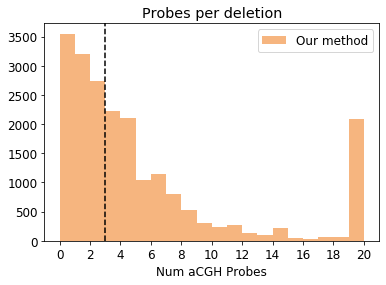

In [108]:
plt.hist(np.clip(num_markers, 0, 20), 
         alpha=0.5, bins=np.arange(0, 21, 1), color=colors[0], label='Our method')
#plt.hist(np.clip(sebat_num_markers, 0, 20), 
#         alpha=0.5, bins=np.arange(0, 21, 1), color=colors[1], label='Sebat')
plt.legend()
plt.axvline(3, color='black', linestyle='--')
plt.xticks(np.arange(0, 21, 2))
plt.xlabel('Num aCGH Probes')
plt.title('Probes per deletion')
plt.show()

In [109]:
has_acgh = num_markers>2
#sebat_has_acgh = sebat_num_markers>2

lengths = np.array([d['length'] for d in deletions])
#sebat_lengths = np.array([d['length'] for d in sebat_deletions])

#print(lengths.shape, sebat_lengths.shape)

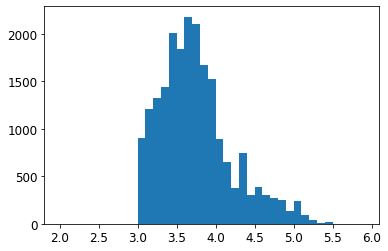

In [110]:
plt.hist(np.log10(lengths), bins=np.arange(2, 6, 0.1))
plt.show()

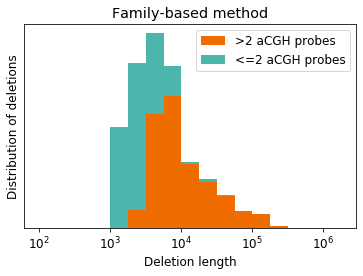

In [111]:
matplotlib.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 2)
plt.title('Family-based method')
plt.xlabel('Deletion length')
plt.hist([np.log10(lengths[has_acgh & ~is_excluded]), 
          np.log10(lengths[~has_acgh & ~is_excluded])],
          bins=np.arange(2, 6.5, 0.25), color=colors[:2], label='Our method', stacked=True)
handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= [">2 aCGH probes","<=2 aCGH probes"]
plt.legend(handles, labels)
plt.xticks(np.arange(2, 7), ['$10^{%d}$' % x for x in np.arange(2, 7)])
plt.yticks([])
plt.ylabel('Distribution of deletions')

#plt.subplot(1, 2, 1)
#plt.title('Brandler 2018 (ensemble method)')
#plt.xlabel('Deletion length')
#plt.hist([np.log10(sebat_lengths[sebat_has_acgh & ~is_sebat_excluded]), 
#          np.log10(sebat_lengths[~sebat_has_acgh & ~is_sebat_excluded])],
#         bins=np.arange(2, 6.5, 0.25), color=colors[:2], label='Our method', stacked=True)
#handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
#labels= [">2 aCGH probes","<=2 aCGH probes"]
#plt.legend(handles, labels)
#plt.xticks(np.arange(2, 7), ['$10^{%d}$' % x for x in np.arange(2, 7)])
#plt.yticks([])
#plt.ylabel('Distribution of deletions')

plt.tight_layout()
#plt.show()
fig.savefig('../plots/acgh_probes.png', dpi=fig.dpi)

In [112]:
#matplotlib.rcParams.update({'font.size': 12})
#
#fig = plt.figure(figsize=(10, 15))#
#
#for i, (t, f, f_sebat) in enumerate([('centromeric', is_cen, is_sebat_cen),
#                                     ('pericentromeric', is_pericen, is_sebat_pericen),
#                                 ('STR', is_str, is_sebat_str),
#                                 ('SegDup', is_segdup, is_sebat_segdup),
#                                 ('Unmap', is_unmap, is_sebat_unmap),
#                                 ('ab_parts', is_abparts, is_sebat_abparts),
#                                 ('TGR', is_tcr, is_sebat_tcr)]):
#    plt.subplot(7, 2, 2*i+1)
#    plt.title('Brandler ' + t)
#    plt.xlabel('Deletion length')
#    plt.hist([np.log10(sebat_lengths[sebat_has_acgh & f_sebat]), 
#              np.log10(sebat_lengths[~sebat_has_acgh & f_sebat])],
#             bins=np.arange(2, 6.5, 0.25), color=colors[:2], label='Our method', stacked=True)
#    handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
#    labels= [">2 aCGH probes","<=2 aCGH probes"]
#    plt.legend(handles, labels)
#    plt.xticks(np.arange(2, 7), ['$10^{%d}$' % x for x in np.arange(2, 7)])
#    plt.yticks([])
#    plt.ylabel('Distribution of deletions')#
#
#    plt.subplot(7, 2, 2*i+2)
#    plt.title('Family-based ' + t)
#    plt.xlabel('Deletion length')
#    plt.hist([np.log10(lengths[has_acgh & f]), 
#              np.log10(lengths[~has_acgh & f])],
#              bins=np.arange(2, 6.5, 0.25), color=colors[:2], label='Our method', stacked=True)
#    handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
#    labels= [">2 aCGH probes","<=2 aCGH probes"]
#    plt.legend(handles, labels)
#    plt.xticks(np.arange(2, 7), ['$10^{%d}$' % x for x in np.arange(2, 7)])
#    plt.yticks([])
#    plt.ylabel('Distribution of deletions')
##
##
#
#plt.tight_layout()
#plt.show()


In [113]:
acgh = np.log2([d['med_aCGH'] for d in deletions])
#sebat_acgh = np.log2([d['med_aCGH'] for d in sebat_deletions])
                             

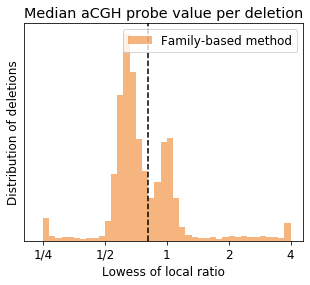

In [117]:
matplotlib.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(5, 4))
#plt.hist(np.clip(sebat_acgh[sebat_has_acgh & ~is_sebat_excluded], -2, 2), 
#         alpha=0.5, bins=np.arange(-2.1, 2.1, 0.1), color=colors[1], label='Brandler 2018', density=True)
plt.hist(np.clip(acgh[has_acgh], -2, 2), 
         alpha=0.5, bins=np.arange(-2.1, 2.1, 0.1), color=colors[0], label='Family-based method', density=True)

plt.axvline(-0.3, color='black', linestyle='--')
plt.legend()
plt.xlabel('Lowess of local ratio')
plt.title('Median aCGH probe value per deletion')
plt.xticks(np.arange(-2, 3), ['1/4', '1/2', '1', '2', '4'])
plt.yticks([])
plt.ylabel('Distribution of deletions')
#plt.show()
fig.savefig('../plots/med_acgh.png', dpi=fig.dpi)

In [115]:
#matplotlib.rcParams.update({'font.size': 12})
#
##fig = plt.figure(figsize=(10, 10))
#for i, (t, f, f_sebat) in enumerate([('centromeric', is_cen, is_sebat_cen),
#                                     ('pericentromeric', is_pericen, is_sebat_pericen),
#                                 ('STR', is_str, is_sebat_str),
#                                 ('SegDup', is_segdup, is_sebat_segdup),
#                                 ('Unmap', is_unmap, is_sebat_unmap),
#                                 ('ab_parts', is_abparts, is_sebat_abparts),
#                                 ('TGR', is_tcr, is_sebat_tcr)]):
#    plt.subplot(4, 2, i+1)
#    plt.hist(np.clip(sebat_acgh[sebat_has_acgh & f_sebat], -2, 2), 
#             alpha=0.5, bins=np.arange(-2.1, 2.1, 0.1), color=colors[1], label='Brandler 2018', density=True)
#    plt.hist(np.clip(acgh[has_acgh & f], -2, 2), 
#             alpha=0.5, bins=np.arange(-2.1, 2.1, 0.1), color=colors[0], label='Family-based method', density=True)#
#
#    plt.axvline(-0.3, color='black', linestyle='--')
##    plt.legend()
##    plt.xlabel('Lowess of local ratio')
#    plt.title('Median aCGH ' + t)
#    plt.xticks(np.arange(-2, 3), ['1/4', '1/2', '1', '2', '4'])
#    plt.yticks([])
#    plt.ylabel('Distribution of deletions')
#    
#plt.tight_layout()
#plt.show()
#fig.savefig('../plots/med_acgh.png', dpi=fig.dpi)

In [118]:
print(np.sum(has_acgh))

11436


In [119]:
#print(np.sum(acgh[has_acgh & ~is_excluded]<-0.3)/np.sum(has_acgh & ~is_excluded), np.sum(sebat_acgh[sebat_has_acgh & ~is_sebat_excluded]<-0.3)/np.sum(sebat_has_acgh & ~is_sebat_excluded))
#print()
#for t, f, f_sebat in [('centromeric', is_cen, is_sebat_cen),
#                      ('pericentromeric', is_pericen, is_sebat_pericen),
#                                 ('STR', is_str, is_sebat_str),
#                                 ('SegDup', is_segdup, is_sebat_segdup),
#                                 ('Unmap', is_unmap, is_sebat_unmap),
#                                 ('ab_parts', is_abparts, is_sebat_abparts),
#                                 ('TGR', is_tcr, is_sebat_tcr)]:
#    print(t, np.sum(acgh[has_acgh & f]<-0.3)/np.sum(has_acgh & f),
#          np.sum(sebat_acgh[sebat_has_acgh & f_sebat]<-0.3)/np.sum(sebat_has_acgh & f_sebat))


In [120]:
is_val_acgh = acgh<-0.3
#sebat_is_val_acgh = sebat_acgh<-0.3


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [121]:
quality_score = np.array([-1 if d['quality_score'] is None else d['quality_score'] for d in deletions])
has_quality_score = quality_score != -1

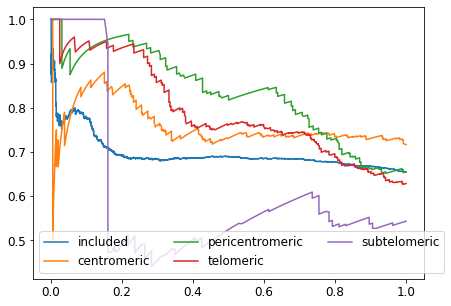

In [124]:
plt.figure(figsize=(7, 5))
precision, recall, _ = precision_recall_curve(is_val_acgh[has_quality_score & has_acgh],
                                            quality_score[has_quality_score & has_acgh])
plt.plot(recall, precision, label='included')

for t, f in [('centromeric', is_cen),
                      ('pericentromeric', is_pericen),
             ('telomeric', is_tel),
                      ('subtelomeric', is_subtel),
                                 #('STR', is_str),
                                 #('SegDup', is_segdup),
                                 #('Unmap', is_unmap),
                                 #('ab_parts', is_abparts),
                     #('TCR', is_tcr, is_sebat_tcr),
                     #('LCR', is_lcr)
            ]:
    precision, recall, _ = precision_recall_curve(is_val_acgh[has_quality_score & has_acgh & f],
                                            quality_score[has_quality_score & has_acgh & f])
    plt.plot(recall, precision, label=t)

    
plt.legend(ncol=3)
    
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in long_scalars


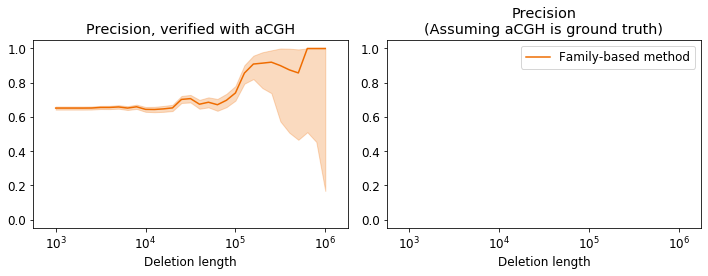

In [135]:
fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)

bins = np.arange(3, 6.1, 0.1).tolist()

percent_val = np.zeros((len(bins),))
percent_val_ub, percent_val_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
#plt.xticks(np.arange(2, 7), ['$10^{%d}$' % x for x in np.arange(2, 7)])

for i, j in enumerate(bins):
    x = np.sum((np.log10(lengths)>=j) & has_acgh & is_val_acgh & ~is_excluded)
    n = np.sum((np.log10(lengths)>=j) & has_acgh & ~is_excluded)
    percent_val[i] = x/n
    percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')

plt.plot(bins, percent_val, label='Family-based method', color=colors[0])
plt.fill_between(bins, percent_val_ub, percent_val_lb, color=colors[0], alpha=0.25)

plt.xlabel('Deletion length')
plt.title('Precision, verified with aCGH')
plt.ylim([-0.05, 1.05])
plt.xticks(np.arange(3, 7), ['$10^{%d}$' % x for x in np.arange(3, 7)])
plt.xlim([2.75, 6.25])
plt.tight_layout()

plt.subplot(1, 2, 2)

bins = np.arange(10, 150, 10)

percent_val = np.zeros((len(bins)-1,))
percent_val_ub, percent_val_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))
#plt.xticks(np.arange(2, 7), ['$10^{%d}$' % x for x in np.arange(2, 7)])

for i, j in enumerate(bins[:-1]):
    x = np.sum((np.log10(lengths)>=j) & has_acgh & is_val_acgh & ~is_excluded)
    n = np.sum((np.log10(lengths)>=j) & has_acgh & ~is_excluded)
    percent_val[i] = x/n
    percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')

plt.plot(bins[:-1], percent_val, label='Family-based method', color=colors[0])
plt.fill_between(bins[:-1], percent_val_ub, percent_val_lb, color=colors[0], alpha=0.25)

plt.xlabel('Deletion length')
plt.legend()
plt.title('Precision\n(Assuming aCGH is ground truth)')
plt.ylim([-0.05, 1.05])
plt.xticks(np.arange(3, 7), ['$10^{%d}$' % x for x in np.arange(3, 7)])
plt.xlim([2.75, 6.25])
plt.tight_layout()

#plt.show()
fig.savefig('../plots/acgh_val.png', dpi=fig.dpi)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in long_scalars


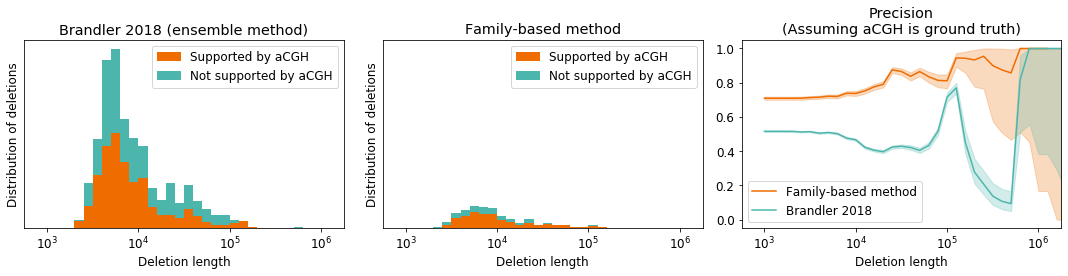

In [155]:
bins = np.arange(0, 150, 10)
fig = plt.figure(figsize=(15, 4))

bins = np.arange(3, 6.5, 0.1).tolist() + [7]
ax = plt.subplot(1, 3, 1)
chip_mark_del_n, _, _ = plt.hist([np.clip(np.log10(sebat_lengths)[sebat_has_acgh & sebat_is_val_acgh & ~is_sebat_excluded], 0, 6), 
                                  np.clip(np.log10(sebat_lengths)[sebat_has_acgh & ~sebat_is_val_acgh & ~is_sebat_excluded], 0, 6)], bins=bins, stacked=True, color=colors[:2])
plt.xlabel('Deletion length')
plt.title('Brandler 2018 (ensemble method)')
plt.ylabel('Distribution of deletions')
plt.yticks([])
handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Supported by aCGH","Not supported by aCGH"]
plt.legend(handles, labels)
#plt.xticks(np.arange(2, 7), ['$10^{%d}$' % x for x in np.arange(2, 7)])
plt.subplot(1, 3, 2, sharex=ax, sharey=ax)
chip_mark_del_n, _, _ = plt.hist([np.clip(np.log10(lengths)[has_acgh & is_val_acgh & ~is_excluded], 0, 6), 
                                  np.clip(np.log10(lengths)[has_acgh & ~is_val_acgh & ~is_excluded], 0, 6)], bins=bins, stacked=True, color=colors[:2])
plt.xlabel('Deletion length')
plt.ylabel('Distribution of deletions')
plt.title('Family-based method')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Supported by aCGH","Not supported by aCGH"]
plt.legend(handles, labels)
plt.yticks([])

plt.subplot(1, 3, 3, sharex=ax)
percent_val = np.zeros((len(bins)-1,))
percent_val_ssc = np.zeros((len(bins)-1,))
percent_val_ub, percent_val_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))
percent_val_ssc_ub, percent_val_ssc_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))
#plt.xticks(np.arange(2, 7), ['$10^{%d}$' % x for x in np.arange(2, 7)])

for i, j in enumerate(bins[:-1]):
    x = np.sum((np.log10(sebat_lengths)>=j) & sebat_has_acgh & sebat_is_val_acgh & ~is_sebat_excluded)
    n = np.sum((np.log10(sebat_lengths)>=j) & sebat_has_acgh & ~is_sebat_excluded)
    percent_val[i] = x/n
    percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    
    x = np.sum((np.log10(lengths)>=j) & has_acgh & is_val_acgh & ~is_excluded)
    n = np.sum((np.log10(lengths)>=j) & has_acgh & ~is_excluded)
    percent_val_ssc[i] = x/n
    percent_val_ssc_ub[i], percent_val_ssc_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')

plt.plot(bins[:-1], percent_val_ssc, label='Family-based method', color=colors[0])
plt.fill_between(bins[:-1], percent_val_ssc_ub, percent_val_ssc_lb, color=colors[0], alpha=0.25)
plt.plot(bins[:-1], percent_val, label='Brandler 2018', color=colors[1])
plt.fill_between(bins[:-1], percent_val_ub, percent_val_lb, color=colors[1], alpha=0.25)

plt.xlabel('Deletion length')
plt.legend()
plt.title('Precision\n(Assuming aCGH is ground truth)')
plt.ylim([-0.05, 1.05])
plt.xticks(np.arange(3, 7), ['$10^{%d}$' % x for x in np.arange(3, 7)])
plt.xlim([2.75, 6.25])
plt.tight_layout()
#plt.show()
fig.savefig('../plots/acgh_val.png', dpi=fig.dpi)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in long_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in long_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in long_scalars


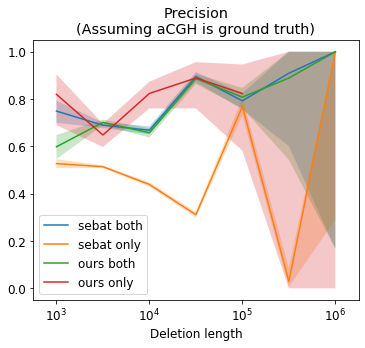

In [132]:
bins = np.arange(0, 150, 10)
fig = plt.figure(figsize=(15, 5))

bins = np.arange(3, 6.5, 0.5).tolist() + [7]


plt.subplot(1, 3, 3, sharex=ax)
percent_val_ours_both = np.zeros((len(bins)-1,))
percent_val_sebat_both = np.zeros((len(bins)-1,))
percent_val_ours_only = np.zeros((len(bins)-1,))
percent_val_sebat_only = np.zeros((len(bins)-1,))
percent_val_ours_both_ub, percent_val_ours_both_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))
percent_val_sebat_both_ub, percent_val_sebat_both_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))
percent_val_ours_only_ub, percent_val_ours_only_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))
percent_val_sebat_only_ub, percent_val_sebat_only_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))

percent_val_sebat_excluded = np.zeros((len(bins)-1,))
percent_val_sebat_excluded_ub, percent_val_sebat_excluded_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))
percent_val_ours_excluded = np.zeros((len(bins)-1,))
percent_val_ours_excluded_ub, percent_val_ours_excluded_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))


for i, j in enumerate(bins[:-1]):
    x = np.sum((np.log10(sebat_lengths)>=j) & (np.log10(sebat_lengths)<bins[i+1]) & sebat_has_acgh & sebat_is_val & sebat_is_val_acgh & ~is_sebat_excluded)
    n = np.sum((np.log10(sebat_lengths)>=j) & (np.log10(sebat_lengths)<bins[i+1]) & sebat_has_acgh & sebat_is_val & ~is_sebat_excluded)
    percent_val_sebat_both[i] = x/n
    percent_val_sebat_both_ub[i], percent_val_sebat_both_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    
    x = np.sum((np.log10(sebat_lengths)>=j) & (np.log10(sebat_lengths)<bins[i+1]) & sebat_has_acgh & ~sebat_is_val & sebat_is_val_acgh & ~is_sebat_excluded)
    n = np.sum((np.log10(sebat_lengths)>=j) & (np.log10(sebat_lengths)<bins[i+1]) & sebat_has_acgh & ~sebat_is_val & ~is_sebat_excluded)
    percent_val_sebat_only[i] = x/n
    percent_val_sebat_only_ub[i], percent_val_sebat_only_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    
    x = np.sum((np.log10(lengths)>=j) & (np.log10(lengths)<bins[i+1]) & has_acgh & is_val & is_val_acgh & ~is_excluded)
    n = np.sum((np.log10(lengths)>=j) & (np.log10(lengths)<bins[i+1]) & has_acgh & is_val & ~is_excluded)
    percent_val_ours_both[i] = x/n
    percent_val_ours_both_ub[i], percent_val_ours_both_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    
    x = np.sum((np.log10(lengths)>=j) & (np.log10(lengths)<bins[i+1]) & has_acgh & ~is_val & is_val_acgh & ~is_excluded)
    n = np.sum((np.log10(lengths)>=j) & (np.log10(lengths)<bins[i+1]) & has_acgh & ~is_val & ~is_excluded)
    percent_val_ours_only[i] = x/n
    percent_val_ours_only_ub[i], percent_val_ours_only_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    
    x = np.sum((np.log10(sebat_lengths)>=j) & (np.log10(sebat_lengths)<bins[i+1]) & sebat_has_acgh & sebat_is_val_acgh & is_sebat_excluded)
    n = np.sum((np.log10(sebat_lengths)>=j) & (np.log10(sebat_lengths)<bins[i+1]) & sebat_has_acgh & is_sebat_excluded)
    percent_val_sebat_excluded[i] = x/n
    percent_val_sebat_excluded_ub[i], percent_val_sebat_excluded_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    
    x = np.sum((np.log10(lengths)>=j) & (np.log10(lengths)<bins[i+1]) & has_acgh & is_val_acgh & is_excluded)
    n = np.sum((np.log10(lengths)>=j) & (np.log10(lengths)<bins[i+1]) & has_acgh & is_excluded)
    percent_val_ours_excluded[i] = x/n
    percent_val_ours_excluded_ub[i], percent_val_ours_excluded_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    
    
plt.plot(bins[:-1], percent_val_sebat_both, label='sebat both')
plt.fill_between(bins[:-1], percent_val_sebat_both_ub, percent_val_sebat_both_lb, alpha=0.25)
plt.plot(bins[:-1], percent_val_sebat_only, label='sebat only')
plt.fill_between(bins[:-1], percent_val_sebat_only_ub, percent_val_sebat_only_lb, alpha=0.25)
plt.plot(bins[:-1], percent_val_ours_both, label='ours both')
plt.fill_between(bins[:-1], percent_val_ours_both_ub, percent_val_ours_both_lb, alpha=0.25)
plt.plot(bins[:-1], percent_val_ours_only, label='ours only')
plt.fill_between(bins[:-1], percent_val_ours_only_ub, percent_val_ours_only_lb, alpha=0.25)
#plt.plot(bins[:-1], percent_val_ours_excluded, label='ours excluded')
#plt.fill_between(bins[:-1], percent_val_ours_excluded_ub, percent_val_ours_excluded_lb, alpha=0.25)
#plt.plot(bins[:-1], percent_val_sebat_excluded, label='sebat excluded')
#plt.fill_between(bins[:-1], percent_val_sebat_excluded_ub, percent_val_sebat_excluded_lb, alpha=0.25)

plt.xlabel('Deletion length')
plt.legend()
plt.title('Precision\n(Assuming aCGH is ground truth)')
plt.ylim([-0.05, 1.05])
plt.xticks(np.arange(3, 7), ['$10^{%d}$' % x for x in np.arange(3, 7)])
plt.xlim([2.75, 6.25])
plt.tight_layout()
plt.show()


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in long_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in long_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a 

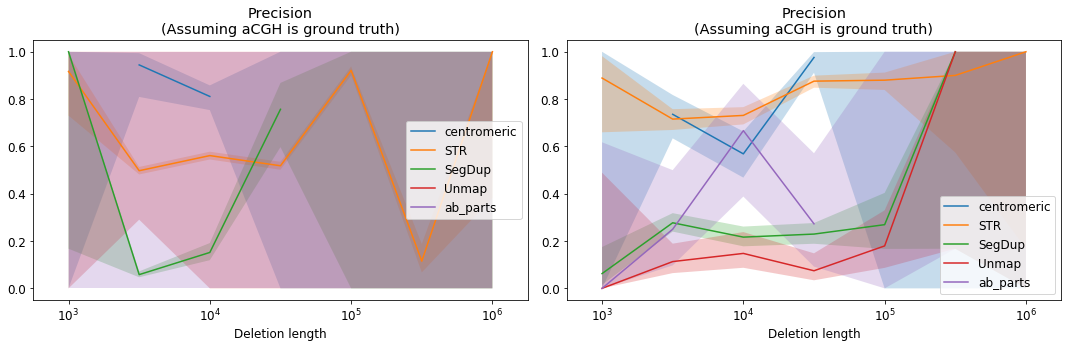

In [133]:
bins = np.arange(0, 150, 10)
fig = plt.figure(figsize=(15, 5))

bins = np.arange(3, 6.5, 0.5).tolist() + [7]

ax = plt.subplot(1, 2, 1)

for k, (t, f, f_sebat) in enumerate([('centromeric', is_cen, is_sebat_cen),
                                 ('STR', is_str, is_sebat_str),
                                 ('SegDup', is_segdup, is_sebat_segdup),
                                 ('Unmap', is_unmap, is_sebat_unmap),
                                 ('ab_parts', is_abparts, is_sebat_abparts)]):
    
    percent_val = np.zeros((len(bins)-1,))
    percent_val_sebat = np.zeros((len(bins)-1,))
    percent_val_ub, percent_val_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))
    percent_val_sebat_ub, percent_val_sebat_lb = np.zeros((len(bins)-1,)), np.zeros((len(bins)-1,))

    for i, j in enumerate(bins[:-1]):
        
        x = np.sum((np.log10(sebat_lengths)>=j) & (np.log10(sebat_lengths)<bins[i+1]) & sebat_has_acgh & sebat_is_val_acgh & f_sebat)
        n = np.sum((np.log10(sebat_lengths)>=j) & (np.log10(sebat_lengths)<bins[i+1]) & sebat_has_acgh & f_sebat)
        percent_val_sebat[i] = x/n
        percent_val_sebat_ub[i], percent_val_sebat_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
        
        x = np.sum((np.log10(lengths)>=j) & (np.log10(lengths)<bins[i+1]) & has_acgh & is_val_acgh & f)
        n = np.sum((np.log10(lengths)>=j) & (np.log10(lengths)<bins[i+1]) & has_acgh & f)
        percent_val[i] = x/n
        percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
        
    plt.subplot(1, 2, 1, sharex=ax)
    plt.plot(bins[:-1], percent_val_sebat, label=t)
    plt.fill_between(bins[:-1], percent_val_sebat_ub, percent_val_sebat_lb, alpha=0.25)

    plt.subplot(1, 2, 2, sharex=ax)
    plt.plot(bins[:-1], percent_val, label=t)
    plt.fill_between(bins[:-1], percent_val_ub, percent_val_lb, alpha=0.25)
    
plt.subplot(1, 2, 1, sharex=ax)
plt.xlabel('Deletion length')
plt.legend()
plt.title('Precision\n(Assuming aCGH is ground truth)')
plt.ylim([-0.05, 1.05])
plt.xticks(np.arange(3, 7), ['$10^{%d}$' % x for x in np.arange(3, 7)])
plt.xlim([2.75, 6.25])

plt.subplot(1, 2, 2, sharex=ax)
plt.xlabel('Deletion length')
plt.legend()
plt.title('Precision\n(Assuming aCGH is ground truth)')
plt.ylim([-0.05, 1.05])
plt.xticks(np.arange(3, 7), ['$10^{%d}$' % x for x in np.arange(3, 7)])
plt.xlim([2.75, 6.25])

plt.tight_layout()
plt.show()


In [134]:
ls = [1000, 5000, 10000, 50000, 100000, 500000]
precision = np.zeros((len(bins)-1,))
sebat_precision = np.zeros((len(bins)-1,))
for i, length in enumerate(ls):
    precision[i] = np.sum((lengths>=length) & has_acgh & is_val_acgh)/np.sum((lengths>=length) & has_acgh)
    sebat_precision[i] = np.sum((sebat_lengths>=length) & sebat_has_acgh & sebat_is_val_acgh)/np.sum((sebat_lengths>=length) & sebat_has_acgh)
    
print(precision)
print(sebat_precision)


[0.65494928 0.66154715 0.65018595 0.70577105 0.74201474 0.85714286
 0.        ]
[0.50563244 0.50041351 0.46517188 0.40528747 0.71603856 0.09345794
 0.        ]


In [135]:
print(np.sum(is_cen))

368


In [146]:
cen_dels = []
cen_del_intervals = set([(deletions[i]['start_pos'], deletions[i]['end_pos']) for i in np.where(is_cen)[0]])
pericen_dels = []
pericen_del_intervals = set([(deletions[i]['start_pos'], deletions[i]['end_pos']) for i in np.where(is_pericen)[0]])

# pull deletions
with open('../phased_ssc_del_qs/deletions.json') as f:
    for d in json.load(f):
        if d['is_inherited'] and not d['is_hts']:
            if (d['start_pos'], d['end_pos']) in cen_del_intervals:
                cen_dels.append(d)
            if (d['start_pos'], d['end_pos']) in pericen_del_intervals:
                pericen_dels.append(d)

print(np.sum(is_cen), len(cen_dels))
print(np.sum(is_pericen), len(pericen_dels))

368 713
311 474


In [147]:
print(Counter([(len(d['trans']), len(d['notrans'])) for d in cen_dels]))
print(Counter([(len(d['trans']), len(d['notrans'])) for d in pericen_dels]))



Counter({(1, 1): 394, (2, 0): 319})
Counter({(1, 1): 246, (2, 0): 228})


In [148]:
sibpair_to_cendel_burden = defaultdict(lambda: np.array([0, 0]))
for d in cen_dels:
    aff_has_del = len([x for x in d['trans'] if child_id_to_affected[ssc_old_id_to_new_id[x]]=='2'])>0
    nt_has_del = len([x for x in d['trans'] if child_id_to_affected[ssc_old_id_to_new_id[x]]=='1'])>0
    sibpair_to_cendel_burden[d['family']] = sibpair_to_cendel_burden[d['family']] + [d['length'] if aff_has_del else 0, d['length'] if nt_has_del else 0]
    
keys = sorted(sibpair_to_cendel_burden.keys())
aut = np.array([sibpair_to_cendel_burden[k][0] for k in keys])
nt = np.array([sibpair_to_cendel_burden[k][1] for k in keys])

    

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


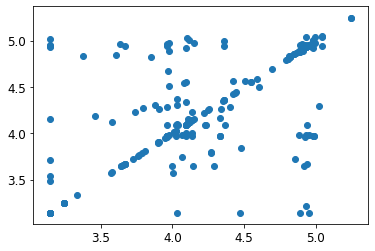

Ttest_relResult(statistic=0.8487349755565854, pvalue=0.3966259329389412)


In [149]:
plt.scatter(np.log10(aut), np.log10(nt))
plt.show()
print(stats.ttest_rel(aut, nt))

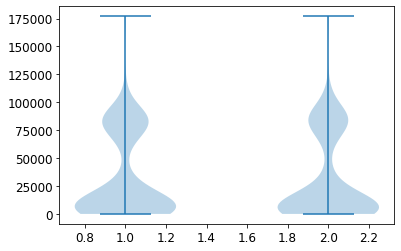

In [150]:
plt.violinplot([aut, nt])
plt.show()

In [141]:
print(Counter([(len([x for x in d['trans'] if child_id_to_affected[ssc_old_id_to_new_id[x]]=='2' and np.log10(d['length'])>4.5]),
                len([x for x in d['trans'] if child_id_to_affected[ssc_old_id_to_new_id[x]]=='1' and np.log10(d['length'])>4.5])) for d in cen_dels]))




Counter({(0, 0): 553, (1, 1): 64, (1, 0): 52, (0, 1): 44})


In [142]:
print(Counter([(len([x for x in d['trans'] if child_id_to_affected[ssc_old_id_to_new_id[x]]=='2' and np.log10(d['length'])>4.5]),
                len([x for x in d['trans'] if child_id_to_affected[ssc_old_id_to_new_id[x]]=='1' and np.log10(d['length'])>4.5])) for d in cen_dels]))




Counter({(0, 0): 553, (1, 1): 64, (1, 0): 52, (0, 1): 44})


In [143]:
print(Counter([(len([x for x in d['trans'] if child_id_to_affected[ssc_old_id_to_new_id[x]]=='2' and np.log10(d['length'])>4.5 and d['is_pat']]),
                len([x for x in d['trans'] if child_id_to_affected[ssc_old_id_to_new_id[x]]=='1' and np.log10(d['length'])>4.5 and d['is_pat']])) for d in cen_dels]))

Counter({(0, 0): 641, (1, 1): 28, (1, 0): 25, (0, 1): 19})


In [144]:
print(stats.binom_test(25, 25+19))

0.4513808323961254


(array([40., 86., 81., 94., 50., 12., 58.,  6., 43.,  2.,  1.,  0.,  1.,
         0.]),
 array([3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2, 5.4,
        5.6, 5.8]),
 <a list of 14 Patch objects>)

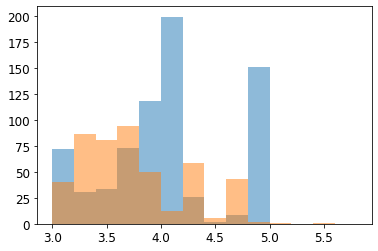

In [154]:
plt.hist(np.log10([d['length'] for d in cen_dels]), alpha=0.5, bins=np.arange(3, 6, 0.2))
plt.hist(np.log10([d['length'] for d in pericen_dels]), alpha=0.5, bins=np.arange(3, 6, 0.2))